### 학습목표
- transformers기반의 Bert 모델 파인튜닝
- pytorch로 구현된 코드 활용
- 허깅페이스 hub를 이용하는 법 실습

In [1]:
# 작업디렉토리 변경
%cd "drive/MyDrive/Colab Notebooks/25.08.04 시각지능 활용(컴퓨터비전 A반)"

/content/drive/MyDrive/Colab Notebooks/25.08.04 시각지능 활용(컴퓨터비전 A반)


### 0.환경설정
- 허깅페이스의 transformers, datasets 라이브러리 설치

In [2]:
!pip install transformers datasets

### 1.데이터 로딩

In [3]:
from datasets import load_dataset

In [ ]:
dataset = load_dataset(
    'csv', # 읽고 싶은 데이터 형식
    data_files = { # 읽고 싶은 데이터 경로
        "train" : "./data/unsmile_train_v1.0.tsv",
        "test" : "./data/unsmile_valid_v1.0.tsv"
    },
    sep = "\t"
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['문장', '여성/가족', '남성', '성소수자', '인종/국적', '연령', '지역', '종교', '기타 혐오', '악플/욕설', 'clean', '개인지칭'],
        num_rows: 15005
    })
    test: Dataset({
        features: ['문장', '여성/가족', '남성', '성소수자', '인종/국적', '연령', '지역', '종교', '기타 혐오', '악플/욕설', 'clean', '개인지칭'],
        num_rows: 3737
    })
})

In [ ]:
dataset["train"][0]

{'문장': '일안하는 시간은 쉬고싶어서 그런게 아닐까',
 '여성/가족': 0,
 '남성': 0,
 '성소수자': 0,
 '인종/국적': 0,
 '연령': 0,
 '지역': 0,
 '종교': 0,
 '기타 혐오': 0,
 '악플/욕설': 0,
 'clean': 1,
 '개인지칭': 0}

In [ ]:
dataset["train"][0].keys()

dict_keys(['문장', '여성/가족', '남성', '성소수자', '인종/국적', '연령', '지역', '종교', '기타 혐오', '악플/욕설', 'clean', '개인지칭'])

In [10]:
# 사용할 정답라벨 정리
unsmile_label = ['여성/가족', '남성', '성소수자', '인종/국적', '연령', '지역', '종교', '기타 혐오', '악플/욕설', 'clean']

### 2.학습을 위한 클래스 준비

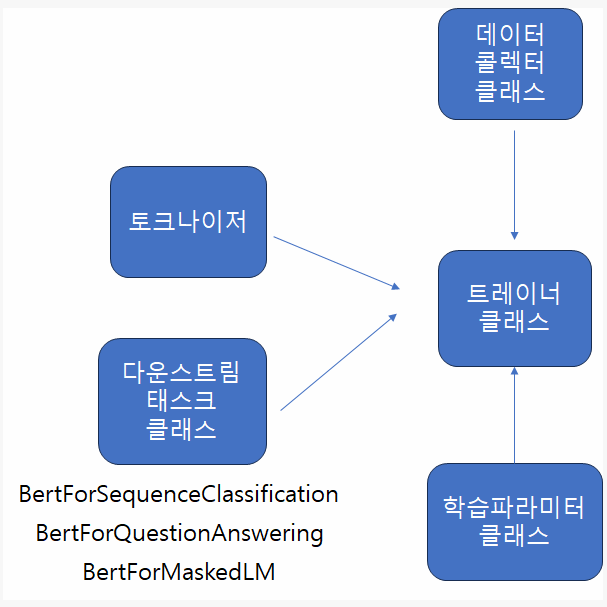

In [4]:
from transformers import BertForSequenceClassification # Bert기반의 문서분류를 수행하는 다운스트림 태스크 클래스
from transformers import AutoTokenizer # 토크나이저를 자동으로 다운로드하는 클래스
from transformers import Trainer # 학습을 수행하는 클래스
from transformers import DataCollatorWithPadding # 데이터를 관리하는 클래스(패딩작업, 배치단위 관리 등)
from transformers import TrainingArguments # 학습에 사용되는 파라미터를 관리하는 클래스

In [8]:
# 사용할 사전학습 모델
# 네이버 뉴스 댓글을 학습시킨 모델
model_name = "beomi/kcbert-base"

#### 토크나이저 로딩

In [ ]:
# 사전학습 모델에 맞는 토크나이저 다운로드
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

In [ ]:
# 샘플문장 변경
tokenizer(dataset["train"][0]['문장'])

{'input_ids': [2, 2458, 15751, 24930, 24351, 29278, 17038, 11631, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
 # 학습을 위한 전처리 함수 만들기
 import torch

In [ ]:
def preprocessing(document) : # 매개변수로 데이터셋 1개가 들어오도록 함
  # 1.문장데이터를 토큰화, 수치화
  token_str = tokenizer(document['문장'])
  # 2.정답데이터를 문제에 추가(문제와 정답을 한 묶음으로 만들기)
  label_list = [ document[class_name] for class_name in unsmile_label ]
  token_str['labels'] = torch.tensor(label_list, dtype=torch.float) # 정답 손실계산을 위해 float로 변경

  return token_str

In [ ]:
# 모든 데이터 전처리함수 적용
tokenized_dataset = dataset.map(preprocessing)

Map:   0%|          | 0/15005 [00:00<?, ? examples/s]

Map:   0%|          | 0/3737 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset['train'][0]

{'문장': '일안하는 시간은 쉬고싶어서 그런게 아닐까',
 '여성/가족': 0,
 '남성': 0,
 '성소수자': 0,
 '인종/국적': 0,
 '연령': 0,
 '지역': 0,
 '종교': 0,
 '기타 혐오': 0,
 '악플/욕설': 0,
 'clean': 1,
 '개인지칭': 0,
 'input_ids': [2, 2458, 15751, 24930, 24351, 29278, 17038, 11631, 3],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1],
 'labels': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]}

In [ ]:
# 필요한 컬럼만 남기고 데이터 타입도 텐서로 변경
tokenized_dataset.set_format(type='torch', columns=['input_ids','token_type_ids','attention_mask','labels'])

In [ ]:
tokenized_dataset['train'][0]

{'input_ids': tensor([    2,  2458, 15751, 24930, 24351, 29278, 17038, 11631,     3]),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'labels': tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])}

#### 파인튜닝할 모델 로딩

In [11]:
model = BertForSequenceClassification.from_pretrained(model_name, # base 모델이름
                                                      num_labels=len(unsmile_label), # 클래스 숫자
                                                      problem_type="multi_label_classification") # 멀티라벨 문제

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### 데이터 관리 클래스

In [ ]:
# 배치사이즈 설정
batch_size = 64
# 패딩작업을 실시하는 collator 클래스 생성
# max_length(optional)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#### 학습 파라미터 클래스 설정

In [ ]:
# 학습파라미터 클래스 생성
args = TrainingArguments(
    learning_rate=2e-5, # 학습률
    per_device_train_batch_size = batch_size, # 훈련시 배치사이즈 설정
    per_device_eval_batch_size = batch_size, # 검증시 배치사이즈 설정
    num_train_epochs = 5, # 학습 횟수 설정
    output_dir = "./model_output", # 학습결과가 저장될 경로(모델 체크포인트 같은 역할)
    save_strategy="epoch", # 매번 에포크 마다 파일 저장
    load_best_model_at_end = True, # 학습 종료시 베스트모델 로딩
    greater_is_better=True, # 베스트 모델 저장
    eval_strategy = "epoch", # 매번 에포크 마다 검증결과 출력 evaluation_strategy -> eval_strategy 로 변환됨
    metric_for_best_model = "lrap" # 모델 평가를 위한 도구 설정
    # push_to_hub=True # 모델결과를 허깅페이스에 업로드
)

#### 멀티라벨용 평가함수

In [ ]:
# 멀티라벨 문제 평가함수 설정
from sklearn.metrics import label_ranking_average_precision_score

# torch와 호환을 위해 사용자정의 함수로 감싸준다
def my_metrics(x) :
  return {
      'lrap' : label_ranking_average_precision_score(x.label_ids, x.predictions)
  }

### 3.모델학습

In [ ]:
# 트레이너 클래스 생성
trainer = Trainer(
    model = model, # 학습시킬 다운스트림 태스크 모델
    args = args, # 학습 파라미터 클래스
    processing_class = tokenizer, # 전처리 클래스
    data_collator = data_collator, # 데이터관리 클래스
    compute_metrics = my_metrics, # 평가함수
    train_dataset = tokenized_dataset['train'], # 학습데이터
    eval_dataset = tokenized_dataset['test'] # 검증데이터
)

In [ ]:
import wandb

wandb.init(mode='disabled')

In [ ]:
# 학습실시
trainer.train()

Epoch,Training Loss,Validation Loss,Lrap
1,No log,0.147584,0.857106
2,No log,0.127427,0.875658
3,0.172100,0.122154,0.882319
4,0.172100,0.126241,0.882099
5,0.079800,0.128168,0.881742


TrainOutput(global_step=1175, training_loss=0.11591843706496219, metrics={'train_runtime': 856.7591, 'train_samples_per_second': 87.568, 'train_steps_per_second': 1.371, 'total_flos': 2414916783606012.0, 'train_loss': 0.11591843706496219, 'epoch': 5.0})

#### 4.모델활용하기
- 허깅페이스 업로드 후 사용하기

In [6]:
# 허깅페이스 로그인하기
import huggingface_hub
huggingface_hub.login()

In [13]:
best_model = model.from_pretrained('./model_output/checkpoint-1175')

In [14]:
# 저장소에 업로드시 함께 기입할 정보 작성
kwargs = {
    'finetuned_from' : model.config._name_or_path, # 파인튜닝한 사전학습 모델정보 입력
    'tasks' : 'text-classification', # task 종류 표기
    'dataset' : 'unsmile_data', # 활용한 데이터 셋 표기
    'tags' : ['HHD', '10_class', 'multi_labels'] # 기타 정보 표기
}

In [15]:
# 허깅페이스 업로드
best_model.push_to_hub("heado", # 프로필이름
                    **kwargs) # 기입할 정보 딕셔너리 언팩킹

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  /tmp/tmpe6k_g05_/model.safetensors    :   2%|2         | 9.38MB /  436MB            

CommitInfo(commit_url='https://huggingface.co/heado/heado/commit/3d0e60709152ee81e5ba673286ee9dfb197ed4c8', commit_message='Upload BertForSequenceClassification', commit_description='', oid='3d0e60709152ee81e5ba673286ee9dfb197ed4c8', pr_url=None, repo_url=RepoUrl('https://huggingface.co/heado/heado', endpoint='https://huggingface.co', repo_type='model', repo_id='heado/heado'), pr_revision=None, pr_num=None)

In [18]:
# 허깅페이스에 올라간 모델 활용하기
from transformers import pipeline

In [23]:
my_unsmile_model = pipeline(task="text-classification", # 태스크 종류
                            model="heado/model_output", # 사용할 모델 저장소
                            device = 0, # 예측할때 GPU 자원을 활용하고 싶은 경우
                            return_all_scores=True) # multi_label 문제이기 때문에 전체 클래스 확률을 보내도록 설정

Device set to use cpu


In [24]:
my_unsmile_model("틀니 압수할께요. 홍어 잘 먹게 생겼다")

[[{'label': 'LABEL_0', 'score': 0.012330553494393826},
  {'label': 'LABEL_1', 'score': 0.022931139916181564},
  {'label': 'LABEL_2', 'score': 0.020073115825653076},
  {'label': 'LABEL_3', 'score': 0.02285541221499443},
  {'label': 'LABEL_4', 'score': 0.7352501749992371},
  {'label': 'LABEL_5', 'score': 0.5056109428405762},
  {'label': 'LABEL_6', 'score': 0.02080480195581913},
  {'label': 'LABEL_7', 'score': 0.024547714740037918},
  {'label': 'LABEL_8', 'score': 0.025610066950321198},
  {'label': 'LABEL_9', 'score': 0.03126352280378342}]]